# BiteMe | Exploratory Data Analysis

In this notebook we analyse our images to help inform modelling.

Here are some questions and identified complexities I have about this project:
 - Sample sizes are very small
 - Data have been collected by non-clinicians. Mis-labelled images might exist in an already small dataset.
 - Other classes exist (spiders, lice etc.)
 - Intra classes exist (bees vs hornets)
 - Skin tone is not addressed - the dataset is wholly white skin as I could not source any other skin tones. No class images therefore had to be solely white skinned too. 
 - Skin tone regardless of ethnicity is difficult regardless. The image recognition will largely be dependent on hue, so we can't mitigate this complexity by turning images to grayscale.
 - No class images are hard to source and have questions. Do we include plain images with no bites? Do we include other dermatological conditions (e.g. acne, moles) to challenge the algorithm?
 - Should we have an "insect bite detector" (object detection for insect bites) sitting above the classifier? We can create localised images to detect, classify each localised bite and average across all detected images (we can even use metadata to assist with bites more likely to be numerous vs singular, spread apart vs clustered together etc.)

In [65]:
import pandas as pd
import numpy as np
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn

import cv2
import albumentations as A
import imgaug as ia
import imgaug.augmenters as iaa

sys.path.append("..")
from helpers import read_images, display_img

plt.rcParams["figure.figsize"] = (14, 8)

In [2]:
# Define directories
base_dir_path = "../"

data_dir_path = os.path.join(base_dir_path, "data")
data_clean_dir_path = os.path.join(data_dir_path, "cleaned")

data_dir = os.listdir(data_dir_path)
data_clean_dir = os.listdir(data_clean_dir_path)

metadata_path = os.path.join(data_clean_dir_path, "metadata.csv")
metadata = pd.read_csv(metadata_path)

metadata.head()

img_name  \
0  7059b14d2aa03ed6c4de11afa32591995181d31c.jpg   
1  ea1b100b581fcdb7ddfae52cc62347a99e304ba4.jpg   
2  1a1442990ff143b7560e5757d9f76d37ab007f48.jpg   
3  6eac051b9c45ff6821ec8675216f371711b7cea9.jpg   
4  fc72767f8520df9b2b83941077dc0ee013eb9399.jpg   

                                            img_path label  
0  ../data/cleaned/none/7059b14d2aa03ed6c4de11afa...  none  
1  ../data/cleaned/none/ea1b100b581fcdb7ddfae52cc...  none  
2  ../data/cleaned/none/1a1442990ff143b7560e5757d...  none  
3  ../data/cleaned/none/6eac051b9c45ff6821ec86752...  none  
4  ../data/cleaned/none/fc72767f8520df9b2b8394107...  none

In [3]:
metadata.value_counts("label")

label
tick        29
none        28
mosquito    28
horsefly    28
bedbug      28
ant         26
bee         24
mite        23
dtype: int64

In [4]:
print(f"Number of images: {len(metadata)}")

Number of images: 214


In [5]:
# Set image default dimensions
ROWS = 512
COLS = 512
CHANNELS = 3

SEED = 14

np.random.seed(SEED)
ia.seed(SEED)

In [6]:
img_array = read_images(
    data_dir_path=data_clean_dir_path, 
    rows=ROWS, 
    cols=COLS, 
    channels=CHANNELS, 
    write_images=False, 
    output_data_dir_path=None
)
print(f"Image array shape: {img_array.shape}")

Reading images from: ../data/cleaned
Rows set to 512
Columns set to 512
Channels set to 3
Writing images is set to: False
Reading images...


100%|██████████| 26/26 [00:01<00:00, 24.41it/s]


Image reading complete.
Image array shape: (214, 512, 512, 3)
Image array shape: (214, 512, 512, 3)


### Image Channels

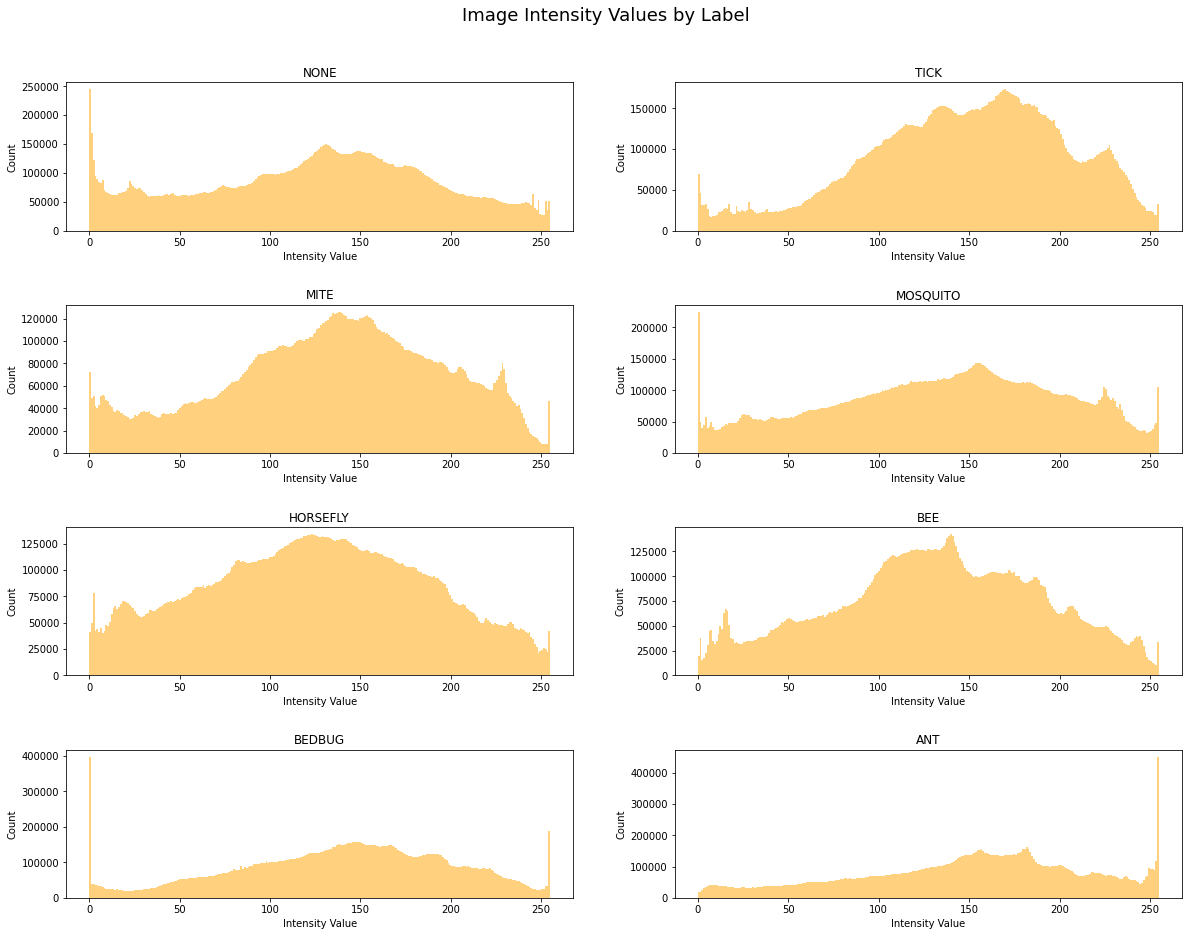

In [133]:
# Plot intensity values by label
labels = metadata["label"].unique()

fig, axs = plt.subplots(nrows=int(len(labels)/2), ncols=2, figsize=(20, 15))
fig.suptitle("Image Intensity Values by Label", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

for label, ax in zip(labels, axs.ravel()):
    # Subset img array to each label
    img_array_subset = img_array[metadata.loc[metadata.label == label].index]
    # Prepare arrays for channel values
    img_vals = np.empty(0)
    
    # Append image label subset values to channel arrays
    for idx, img in enumerate(img_array_subset):
        img_vals = np.append(img_vals, img_array_subset[idx].ravel())

    ax.hist(img_vals, bins = 256, color = "orange", alpha=0.5)
    ax.set_title(label.upper())
    ax.set_xlabel("Intensity Value")
    ax.set_ylabel("Count")

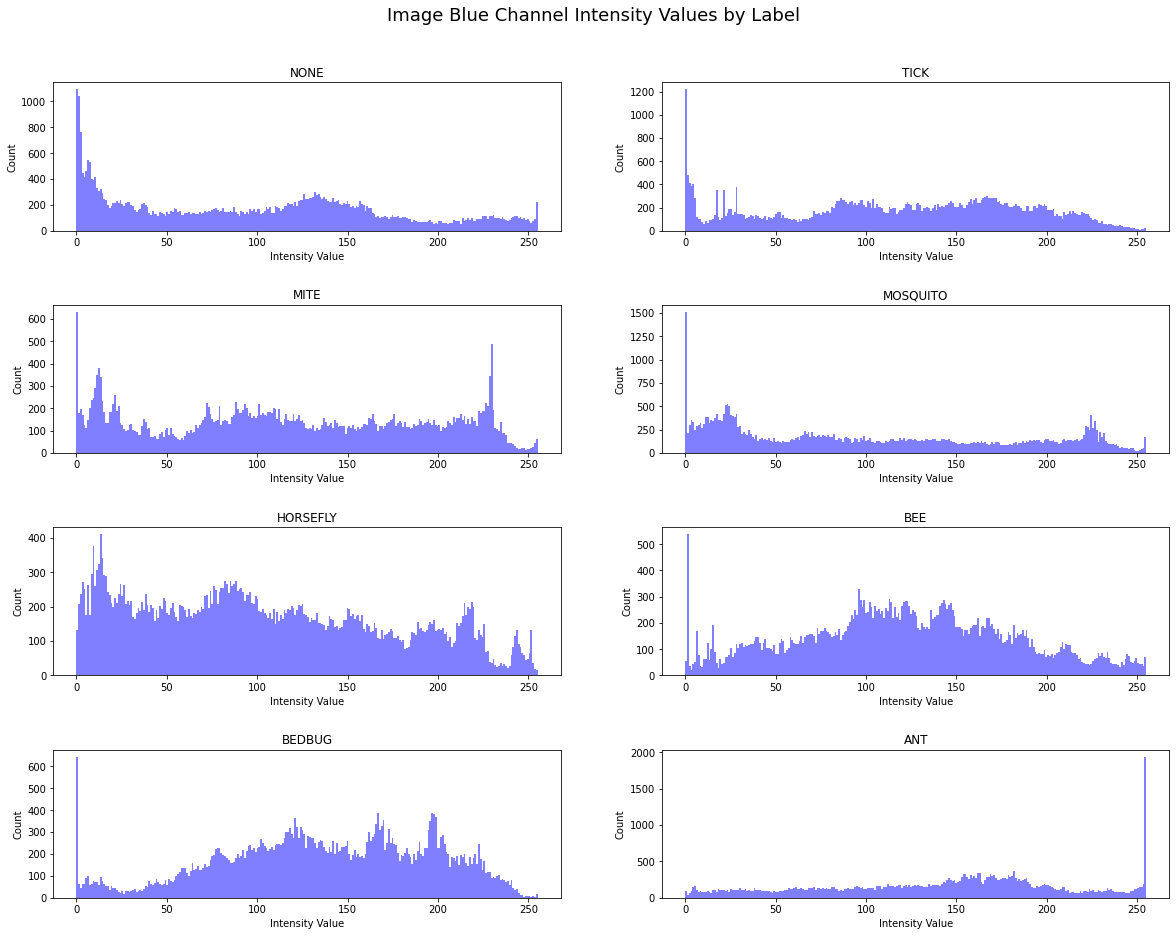

In [134]:
# Plot intensity values by label
labels = metadata["label"].unique()

fig, axs = plt.subplots(nrows=int(len(labels)/2), ncols=2, figsize=(20, 15))
fig.suptitle("Image Blue Channel Intensity Values by Label", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

for label, ax in zip(labels, axs.ravel()):
    # Subset img array to each label
    img_array_subset = img_array[metadata.loc[metadata.label == label].index]
    # Prepare arrays for channel values
    img_vals_b = np.empty(0)
    
    # Append image label subset values to channel arrays
    for idx, img in enumerate(img_array_subset):
        img_vals_b = np.append(img_vals_b, img_array_subset[idx, :, 0].ravel())

    ax.hist(img_vals_b, bins=256, color="blue", alpha=0.5)
    ax.set_title(label.upper())
    ax.set_xlabel("Intensity Value")
    ax.set_ylabel("Count")

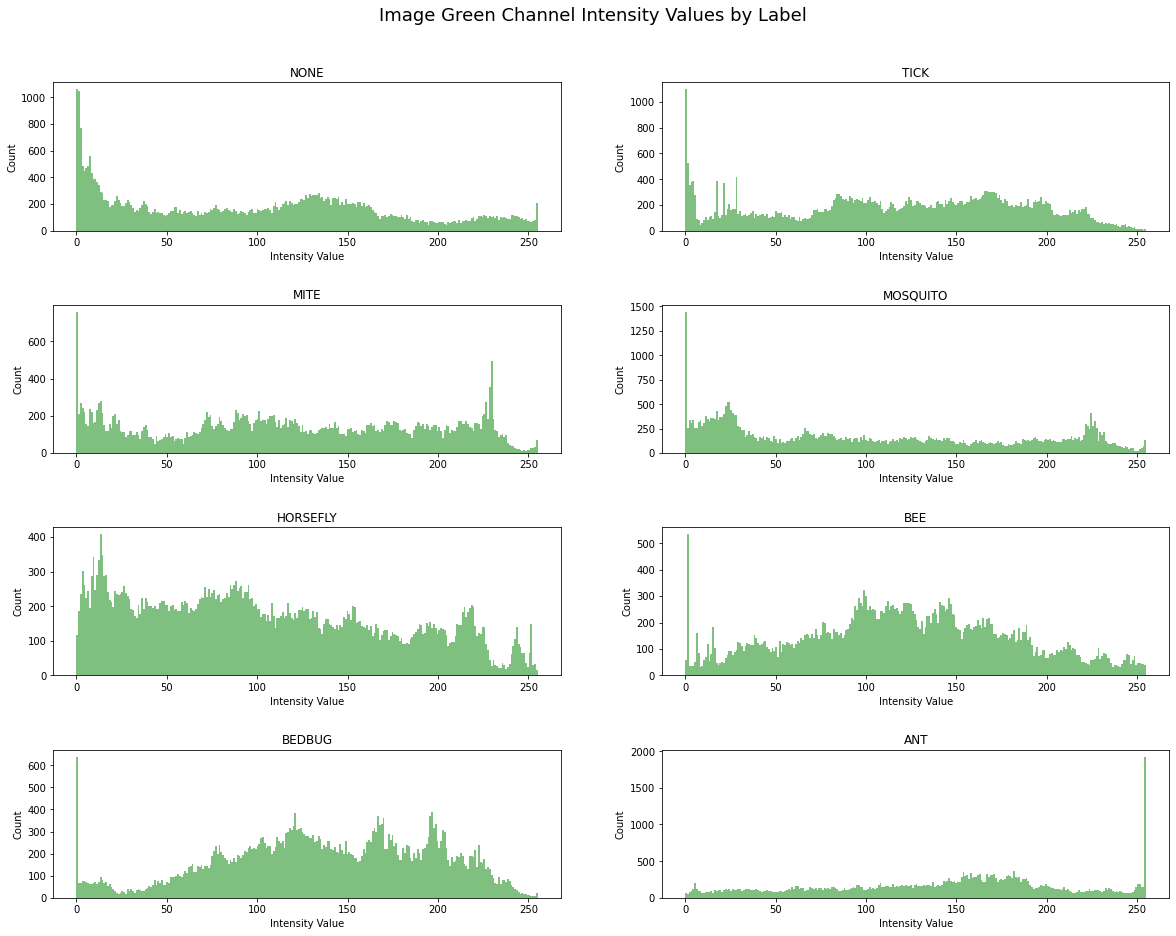

In [135]:
# Plot intensity values by label
labels = metadata["label"].unique()

fig, axs = plt.subplots(nrows=int(len(labels)/2), ncols=2, figsize=(20, 15))
fig.suptitle("Image Green Channel Intensity Values by Label", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

for label, ax in zip(labels, axs.ravel()):
    # Subset img array to each label
    img_array_subset = img_array[metadata.loc[metadata.label == label].index]
    # Prepare arrays for channel values
    img_vals_g = np.empty(0)
    
    # Append image label subset values to channel arrays
    for idx, img in enumerate(img_array_subset):
        img_vals_g = np.append(img_vals_g, img_array_subset[idx, :, 1].ravel())

    ax.hist(img_vals_g, bins=256, color="green", alpha=0.5)
    ax.set_title(label.upper())
    ax.set_xlabel("Intensity Value")
    ax.set_ylabel("Count")

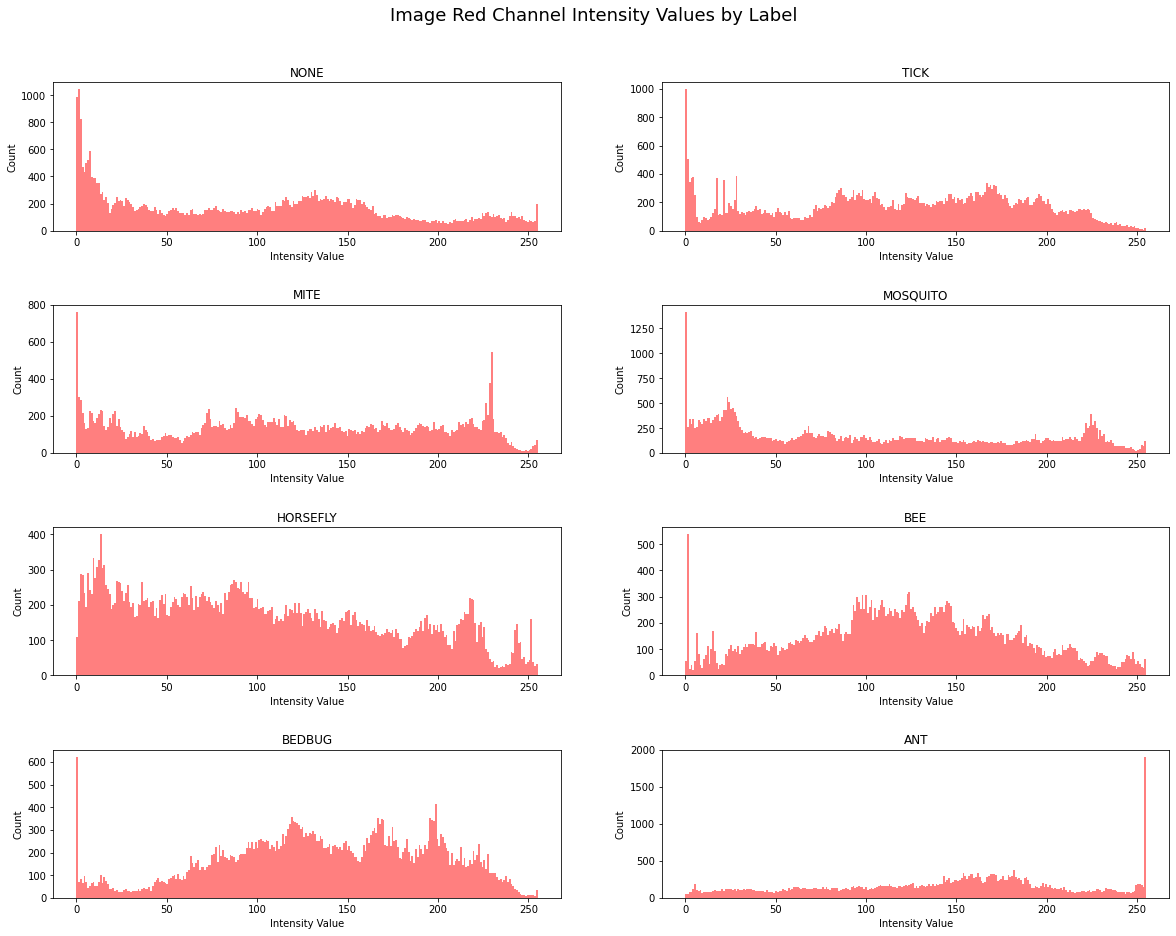

In [136]:
# Plot intensity values by label
labels = metadata["label"].unique()

fig, axs = plt.subplots(nrows=int(len(labels)/2), ncols=2, figsize=(20, 15))
fig.suptitle("Image Red Channel Intensity Values by Label", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

for label, ax in zip(labels, axs.ravel()):
    # Subset img array to each label
    img_array_subset = img_array[metadata.loc[metadata.label == label].index]
    # Prepare arrays for channel values
    img_vals_r = np.empty(0)
    
    # Append image label subset values to channel arrays
    for idx, img in enumerate(img_array_subset):
        img_vals_r = np.append(img_vals_r, img_array_subset[idx, :, 2].ravel())

    ax.hist(img_vals_r, bins=256, color="red", alpha=0.5)
    ax.set_title(label.upper())
    ax.set_xlabel("Intensity Value")
    ax.set_ylabel("Count")

In [137]:
metadata.loc[metadata.label == "ant"]

img_name  \
188  3b52b1448e07be7bda2519088dbbc71c598fd442.jpg   
189  8006343c2718da7f483f41885e7325ada46eea21.jpg   
190  6c47b92ec8500adbc823b2e520f5c87a31c65244.jpg   
191  7b5eef2839635c0d840e00cb6f6f7546f37a5fc2.jpg   
192  7eb341d72ce82ce02594b95f6e1da2d612710bbf.jpg   
193  ea68e9537a5e9ddaac4261887d021d6abd7a061f.jpg   
194  21f1fff73fa5f41bc5012e6aec89d5e030199df7.jpg   
195  aab000bb9c128f02928ea609ecfcf371bb304851.jpg   
196  e25c1ead015e5bc31080a503372ba1e39f416aa4.jpg   
197  86345958e491817bc37db5cfde6e48fe651e595b.jpg   
198  8d90c3c5830929a72ebf2ce69db4d425768538f1.jpg   
199  24aca08f4aeea83c077a9721c85b5a6ff8ef7d3d.jpg   
200  06058baa28ad6587e521e4c4f8256584e91152ac.jpg   
201  3090178d8a48bc3840370986388a82869285841e.jpg   
202  ecc91330a1c99235501bba618fe8aad3cb75dd16.jpg   
203  477e86816e544bcf371c470b65c887567f8fd186.jpg   
204  99f5a9e1e46ee1c05390a119efa93f9780eb920a.jpg   
205  d2d4a895faa8c2f9d5a079666ad1495e81001325.jpg   
206  fc33f1cc78107d74a588db6509346dd4c515b1de.jpg   
207  b629d37023afd3d2074e593a447eff51551fba2f.jpg   
208  f151822590f8f36aeae82a4e3e1037e5f633fceb.jpg   
209  160ba8545fbc59fdb6b87561e3fb7f8050220afa.jpg   
210  4bd8e1b74624bbb4aff0f915aba1b318d30ebd77.jpg   
211  feec138b1173d3232020f7568e059ddcf2466ea9.jpg   
212  534cd8454b5f37df399193b61b05332127ddd2af.jpg   
213  510afe6d46a43f33a7c2ad65846c32834ef4bf98.jpg   

                                              img_path label  
188  ../data/cleaned/ant/3b52b1448e07be7bda2519088d...   ant  
189  ../data/cleaned/ant/8006343c2718da7f483f41885e...   ant  
190  ../data/cleaned/ant/6c47b92ec8500adbc823b2e520...   ant  
191  ../data/cleaned/ant/7b5eef2839635c0d840e00cb6f...   ant  
192  ../data/cleaned/ant/7eb341d72ce82ce02594b95f6e...   ant  
193  ../data/cleaned/ant/ea68e9537a5e9ddaac4261887d...   ant  
194  ../data/cleaned/ant/21f1fff73fa5f41bc5012e6aec...   ant  
195  ../data/cleaned/ant/aab000bb9c128f02928ea609ec...   ant  
196  ../data/cleaned/ant/e25c1ead015e5bc31080a50337...   ant  
197  ../data/cleaned/ant/86345958e491817bc37db5cfde...   ant  
198  ../data/cleaned/ant/8d90c3c5830929a72ebf2ce69d...   ant  
199  ../data/cleaned/ant/24aca08f4aeea83c077a9721c8...   ant  
200  ../data/cleaned/ant/06058baa28ad6587e521e4c4f8...   ant  
201  ../data/cleaned/ant/3090178d8a48bc384037098638...   ant  
202  ../data/cleaned/ant/ecc91330a1c99235501bba618f...   ant  
203  ../data/cleaned/ant/477e86816e544bcf371c470b65...   ant  
204  ../data/cleaned/ant/99f5a9e1e46ee1c05390a119ef...   ant  
205  ../data/cleaned/ant/d2d4a895faa8c2f9d5a079666a...   ant  
206  ../data/cleaned/ant/fc33f1cc78107d74a588db6509...   ant  
207  ../data/cleaned/ant/b629d37023afd3d2074e593a44...   ant  
208  ../data/cleaned/ant/f151822590f8f36aeae82a4e3e...   ant  
209  ../data/cleaned/ant/160ba8545fbc59fdb6b87561e3...   ant  
210  ../data/cleaned/ant/4bd8e1b74624bbb4aff0f915ab...   ant  
211  ../data/cleaned/ant/feec138b1173d3232020f7568e...   ant  
212  ../data/cleaned/ant/534cd8454b5f37df399193b61b...   ant  
213  ../data/cleaned/ant/510afe6d46a43f33a7c2ad6584...   ant

## Example Augmentations

OpenCV reads images in differently to how matplotlib displays them, so for the purposes of displaying example images we'll have to rearrange the channels manually. In modelling, however, this won't be neccessary. But in order to assess certain augmentations, we need to see how it looks in RGB rather than BGR as we won't be able to evaluate it properly otherwise. 

In [7]:
# Get example image
example_img = np.expand_dims(img_array[65][...,::-1], axis=0)

Example images


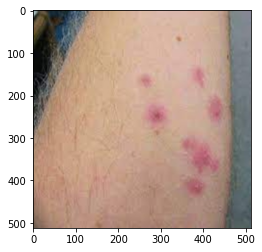

In [8]:
print("Example images")
for img in example_img:
    display_img(img)

### Flip left to right

In [9]:
def display_img_aug(img, aug, *args, **kwargs):
    """
    Displays input image alongside augmented image.
    
    Parameters
    ----------
    img : np.array
        Original image to augment.
    aug : function
        imgaug.augmenters function to augment img with.
    
    Returns
    -------
    plt.figure
    """
    
    seq = iaa.Sequential([
        aug(*args, **kwargs)
    ])
    img_aug = seq(images=img)
    images_aug = np.concatenate([img, img_aug])
    
    for img in images_aug:
        display_img(img)

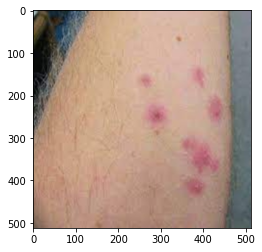

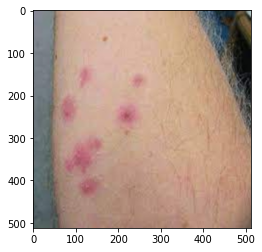

In [10]:
display_img_aug(example_img, iaa.Fliplr, p=1)

### Flip up to down

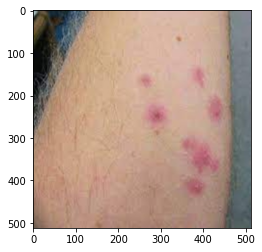

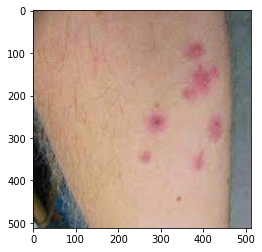

In [11]:
display_img_aug(example_img, iaa.Flipud, p=1)

### Gaussian Blur

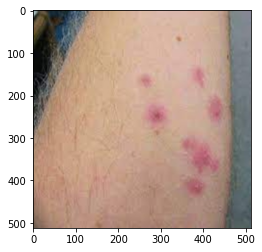

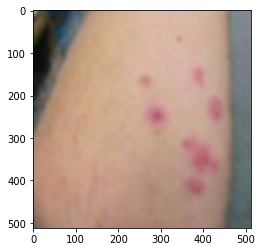

In [12]:
display_img_aug(example_img, iaa.GaussianBlur, sigma=6.0)

### Average Blur

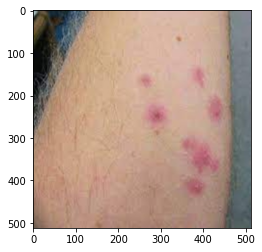

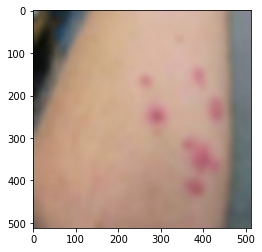

In [13]:
display_img_aug(example_img, iaa.AverageBlur, k=20)

### MotionBlur

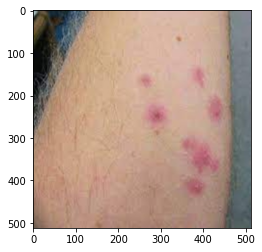

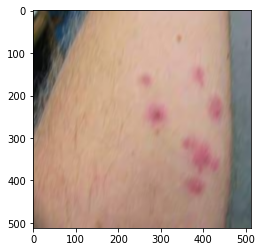

In [14]:
display_img_aug(example_img, iaa.MotionBlur, k=15)

### MultiplyBrightness

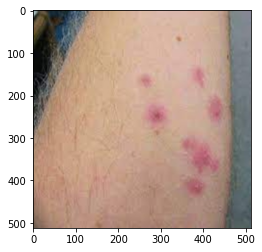

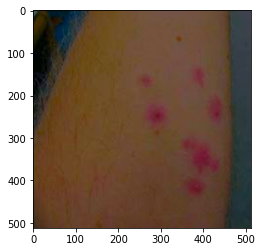

In [15]:
display_img_aug(example_img, iaa.MultiplyBrightness, 0.5)

### MultiplyHue

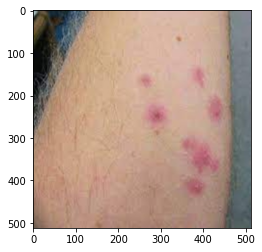

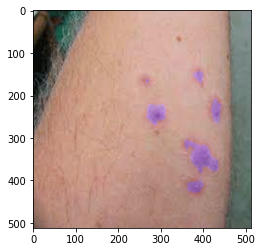

In [16]:
display_img_aug(example_img, iaa.MultiplyHue, 0.8)

### MultiplySaturation

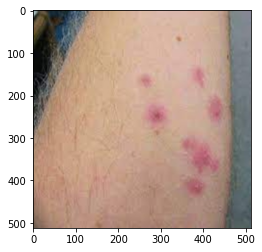

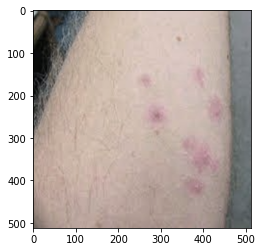

In [17]:
display_img_aug(example_img, iaa.MultiplySaturation, 0.5)

### Grayscale

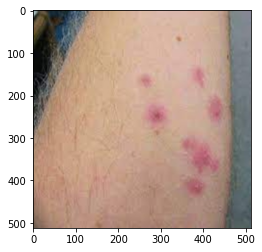

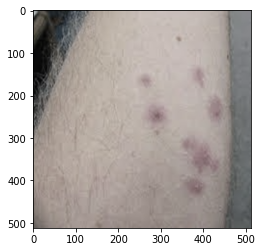

In [18]:
display_img_aug(example_img, iaa.Grayscale, 0.7)

### GammaContrast

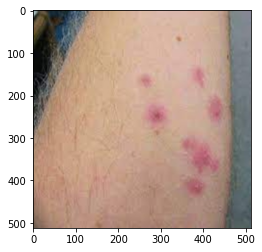

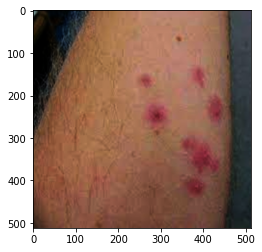

In [19]:
display_img_aug(example_img, iaa.GammaContrast, 2)

### SigmoidContrast

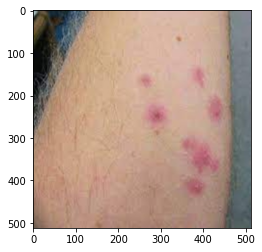

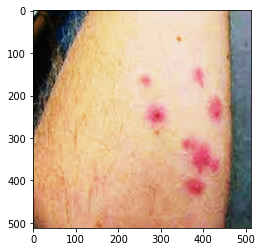

In [20]:
display_img_aug(example_img, iaa.SigmoidContrast, 9)

### LinearContrast

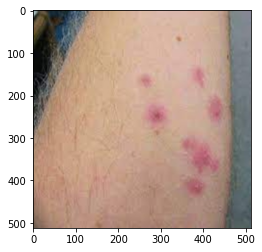

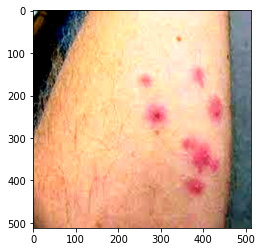

In [21]:
display_img_aug(example_img, iaa.LinearContrast, 2)

### Affine

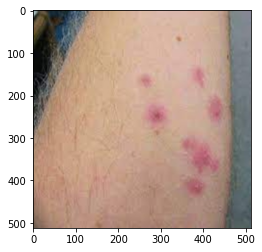

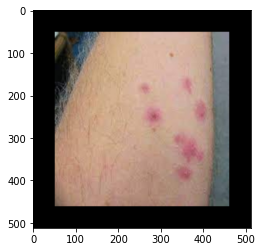

In [22]:
display_img_aug(example_img, iaa.Affine, 0.8)

### ScaleX

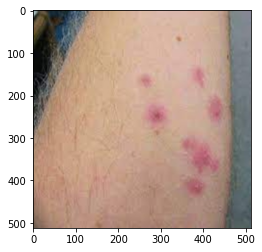

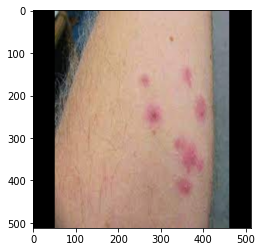

In [23]:
display_img_aug(example_img, iaa.ScaleX, 0.8)

### ScaleY

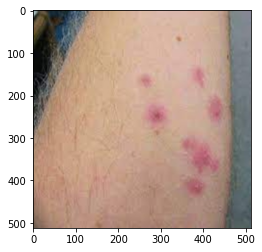

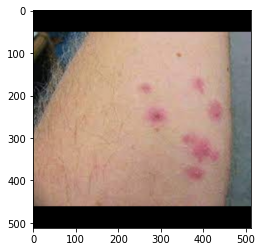

In [24]:
display_img_aug(example_img, iaa.ScaleY, 0.8)

### TranslateX

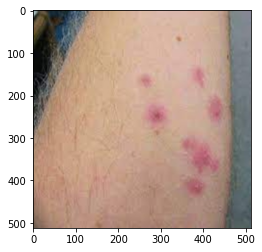

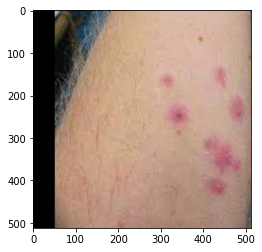

In [25]:
display_img_aug(example_img, iaa.TranslateX, 0.1)

### TranslateY

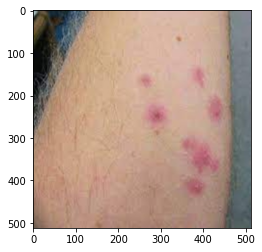

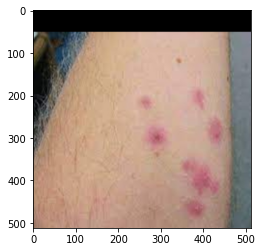

In [26]:
display_img_aug(example_img, iaa.TranslateY, 0.1)

### Rotate

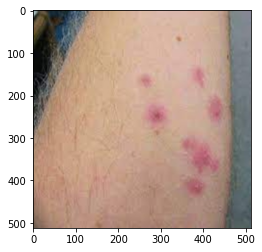

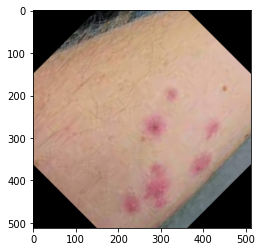

In [27]:
display_img_aug(example_img, iaa.Rotate, 45)

### ShearX

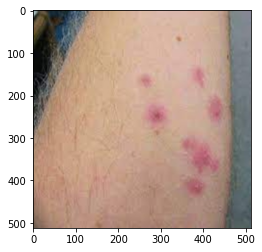

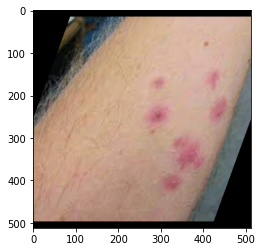

In [28]:
display_img_aug(example_img, iaa.ShearX, 20)

### ShearY

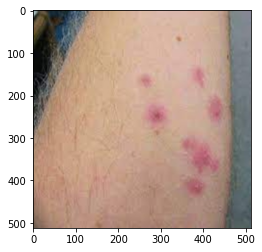

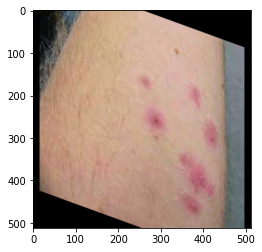

In [29]:
display_img_aug(example_img, iaa.ShearY, 20)

### GaussianNoise

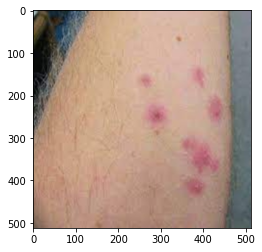

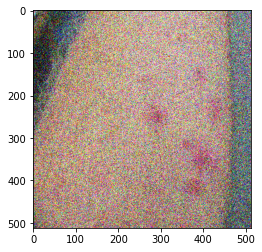

In [35]:
display_img_aug(example_img, iaa.imgcorruptlike.GaussianNoise, severity=5)

### ShotNoise

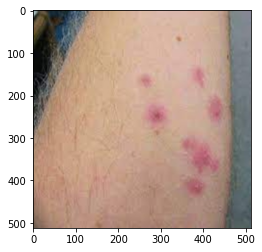

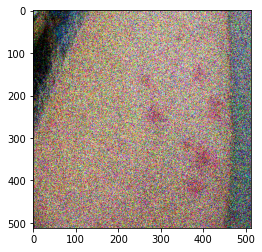

In [36]:
display_img_aug(example_img, iaa.imgcorruptlike.ShotNoise, severity=5)

### ImpulseNoise

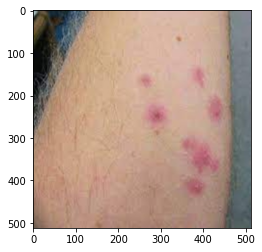

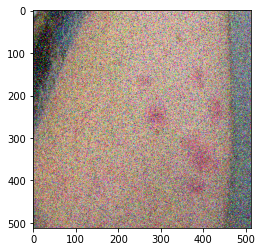

In [37]:
display_img_aug(example_img, iaa.imgcorruptlike.ImpulseNoise, severity=5)

### SpeckleNoise

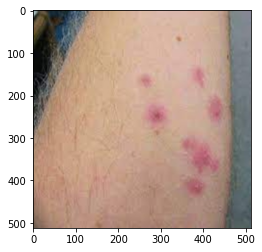

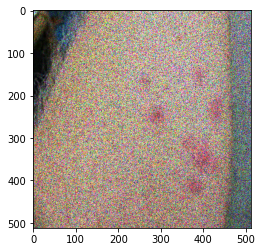

In [38]:
display_img_aug(example_img, iaa.imgcorruptlike.SpeckleNoise, severity=5)

### DefocusBlur

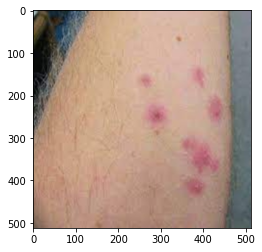

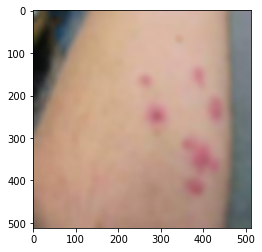

In [39]:
display_img_aug(example_img, iaa.imgcorruptlike.DefocusBlur, severity=5)

### ZoomBlur

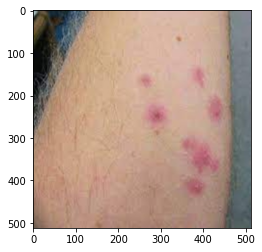

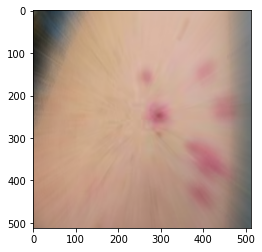

In [41]:
display_img_aug(example_img, iaa.imgcorruptlike.ZoomBlur, severity=4)

### Contrast

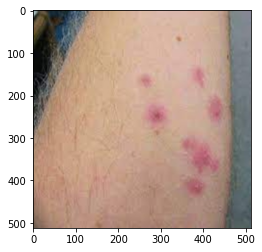

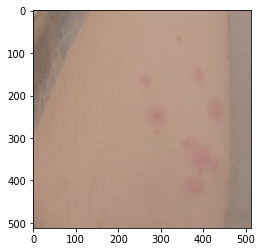

In [42]:
display_img_aug(example_img, iaa.imgcorruptlike.Contrast, severity=2)

### Brightness

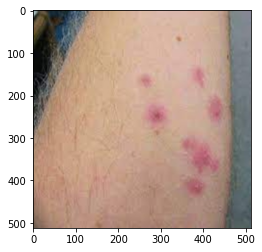

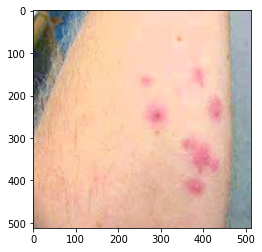

In [43]:
display_img_aug(example_img, iaa.imgcorruptlike.Brightness, severity=2)

### Saturate

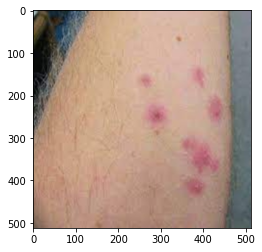

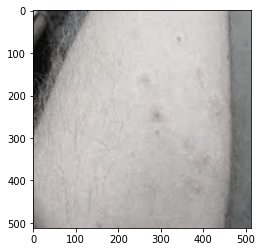

In [44]:
display_img_aug(example_img, iaa.imgcorruptlike.Saturate, severity=2)

### Solarize

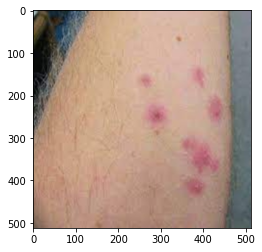

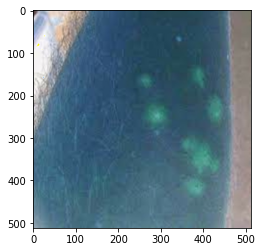

In [51]:
display_img_aug(example_img, iaa.Solarize, threshold=1)

### EnhanceColor

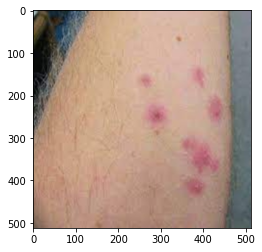

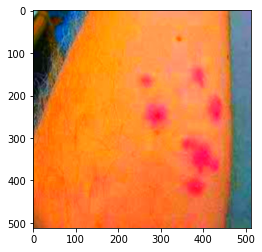

In [73]:
display_img_aug(example_img, iaa.pillike.EnhanceColor, 4)

### EnhanceContrast

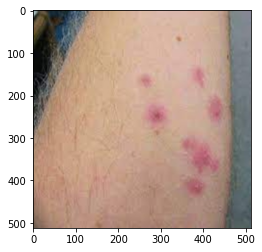

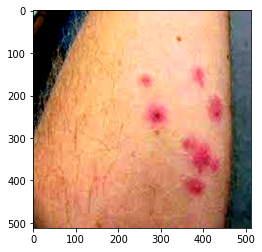

In [75]:
display_img_aug(example_img, iaa.pillike.EnhanceContrast, 2)

### EnhanceBrightness

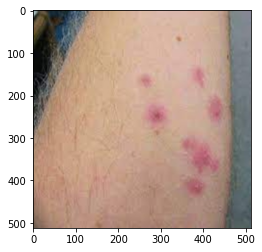

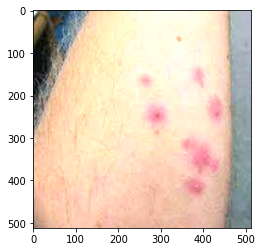

In [81]:
display_img_aug(example_img, iaa.pillike.EnhanceBrightness, 1.4)

### EnhanceSharpness

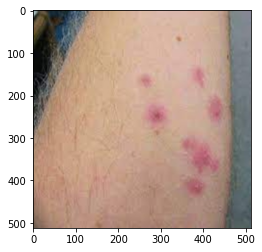

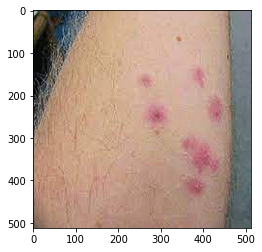

In [93]:
display_img_aug(example_img, iaa.pillike.EnhanceSharpness, 10)

### AdditiveGaussianNoise

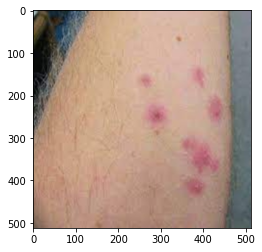

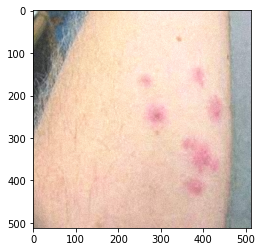

In [97]:
display_img_aug(example_img, iaa.AdditiveGaussianNoise, 50)

### AdditiveLaplaceNoise

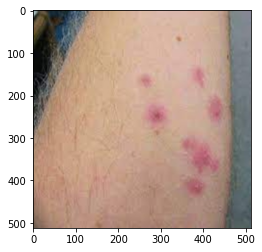

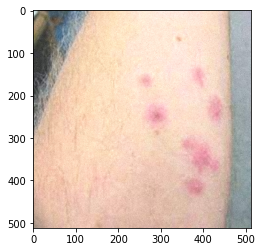

In [99]:
display_img_aug(example_img, iaa.AdditiveLaplaceNoise, 50)

### AdditivePoissonNoise

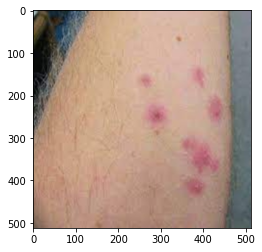

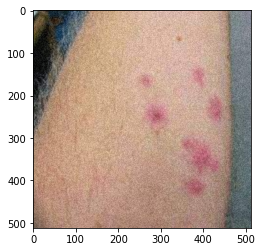

In [102]:
display_img_aug(example_img, iaa.AdditivePoissonNoise, 20)

### Cutout

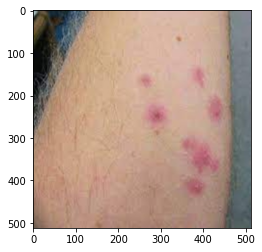

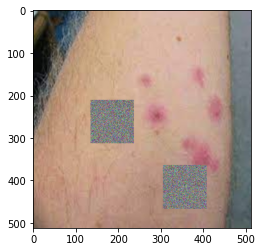

In [119]:
display_img_aug(example_img, iaa.Cutout, 2, size=0.2, fill_mode="gaussian", fill_per_channel=True)

### Dropout

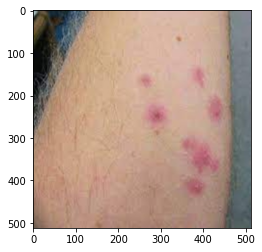

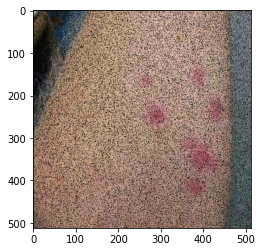

In [125]:
display_img_aug(example_img, iaa.Dropout, p=0.2, per_channel=0.5)

### CoarseDropout

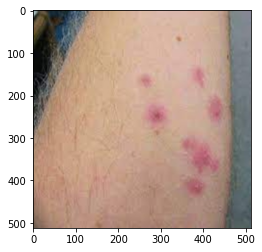

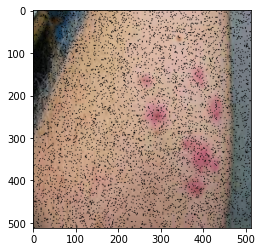

In [126]:
display_img_aug(example_img, iaa.CoarseDropout, size_percent=0.5)


### ImpulseNoise

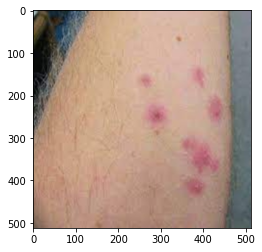

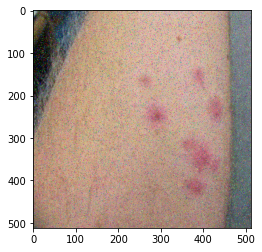

In [127]:
display_img_aug(example_img, iaa.ImpulseNoise, 0.1)

### SaltAndPepper

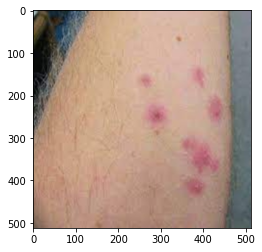

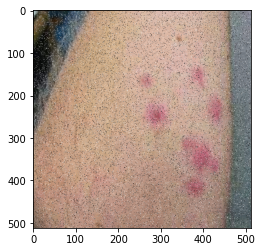

In [128]:
display_img_aug(example_img, iaa.SaltAndPepper, 0.1)